# Telco Customer Churn Feature Engineering

<hr />

## Business Problem

📌 It is desirable to develop a machine learning model that can predict customers who will leave the company. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

## Dataset Story

📌 Telco churn data includes information about a fictitious telecom company that provided home phone and Internet services to 7,043 California customers in the third quarter. It shows which customers have left, stayed or signed up for their service.

CustomerId : Customer ID

Gender: Gender

SeniorCitizen : Whether the client is old (1, 0)

Partner : Whether the client has a partner (Yes, No) ? whether to be married

Dependents: Whether the customer has dependents (Yes, No) (Child, mother, father, grandmother)

tenure : The number of months the customer has stayed with the company

PhoneService : Whether the customer has phone service (Yes, No)

MultipleLines : Whether the customer has more than one line (Yes, No, No Telephone service)

InternetService : Customer's internet service provider (DSL, Fiber optic, No)

OnlineSecurity : Whether the customer has online security (Yes, No, no Internet service)

OnlineBackup : Whether the customer has an online backup (Yes, No, no Internet service)

DeviceProtection : Whether the customer has device protection (Yes, No, no Internet service)

TechSupport : Whether the customer has technical support (Yes, No, no Internet service)

StreamingTV : Whether the customer is broadcasting TV (Yes, No, no Internet service) Indicates whether the customer uses the Internet service to stream television programs from a third-party provider

StreamingMovies : Whether the customer is streaming movies (Yes, No, no Internet service) Indicates whether the customer is using the Internet service to stream movies from a third-party provider

Contract : Contract duration of the client (Month to month, One year, Two years)

PaperlessBilling : Whether the customer has a paperless invoice (Yes, No)

PaymentMethod : Customer's payment method (Electronic check, Postal check, Bank transfer (automatic), Credit card (automatic))

MonthlyCharges : The amount charged monthly from the customer

TotalCharges : The total amount charged from the customer

Churn : Whether the customer uses (Yes or No) - Customers who left in the last month or quarter

## Import Necessary Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = df["Churn"].apply(lambda x: 1 if x=="Yes" else 0)

## General Information About to the Dataset

In [10]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [11]:
check_df(df)

######################### Head #########################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies 

## Analysis of Categorical and Numerical Variables

In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")

Observations: 7043
Variables: 21
Cat_cols: 17
Num_cols: 3
Cat_but_car: 1


In [14]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [15]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

        gender  Ration
Male      3555  50.476
Female    3488  49.524
##########################################


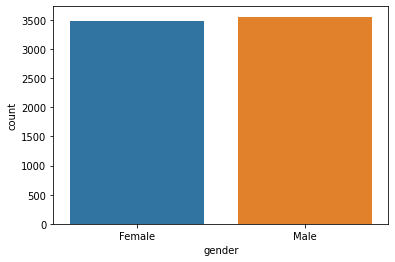

     Partner  Ration
No      3641  51.697
Yes     3402  48.303
##########################################


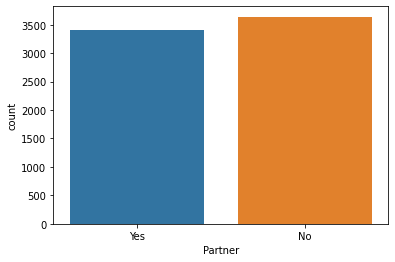

     Dependents  Ration
No         4933  70.041
Yes        2110  29.959
##########################################


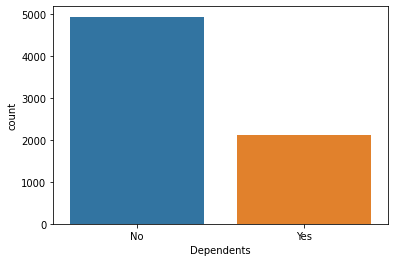

     PhoneService  Ration
Yes          6361  90.317
No            682   9.683
##########################################


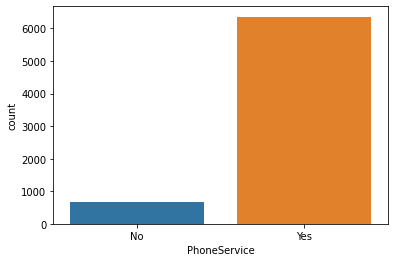

                  MultipleLines  Ration
No                         3390  48.133
Yes                        2971  42.184
No phone service            682   9.683
##########################################


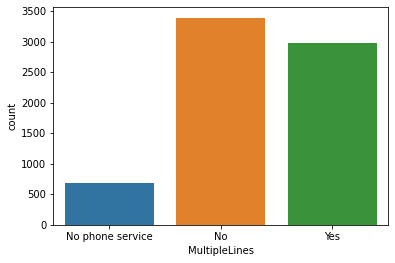

             InternetService  Ration
Fiber optic             3096  43.959
DSL                     2421  34.375
No                      1526  21.667
##########################################


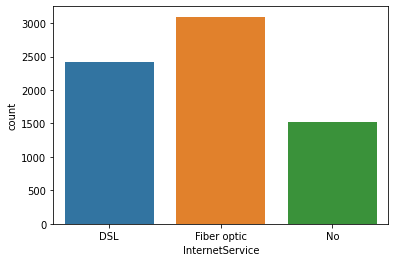

                     OnlineSecurity  Ration
No                             3498  49.666
Yes                            2019  28.667
No internet service            1526  21.667
##########################################


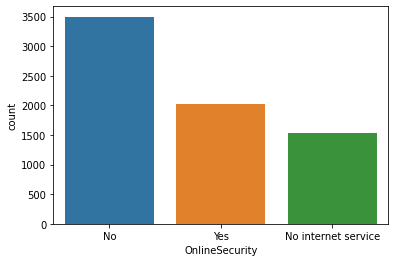

                     OnlineBackup  Ration
No                           3088  43.845
Yes                          2429  34.488
No internet service          1526  21.667
##########################################


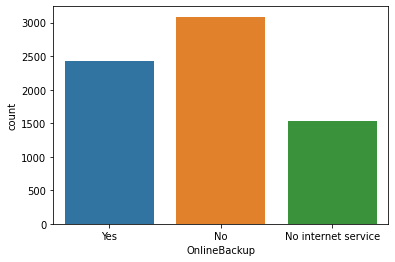

                     DeviceProtection  Ration
No                               3095  43.944
Yes                              2422  34.389
No internet service              1526  21.667
##########################################


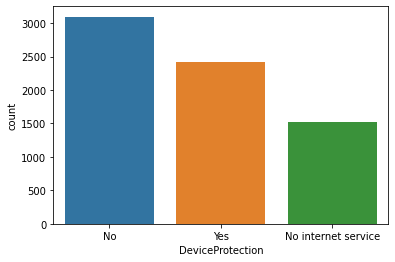

                     TechSupport  Ration
No                          3473  49.311
Yes                         2044  29.022
No internet service         1526  21.667
##########################################


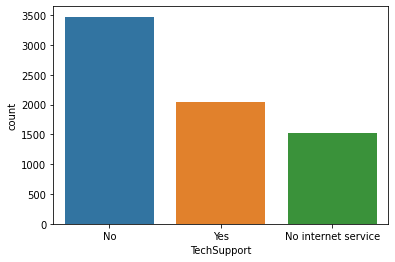

                     StreamingTV  Ration
No                          2810  39.898
Yes                         2707  38.435
No internet service         1526  21.667
##########################################


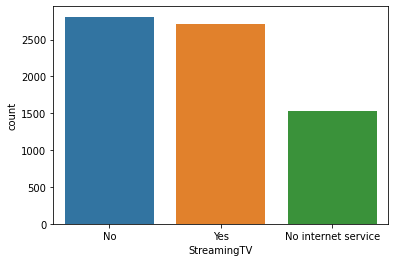

                     StreamingMovies  Ration
No                              2785  39.543
Yes                             2732  38.790
No internet service             1526  21.667
##########################################


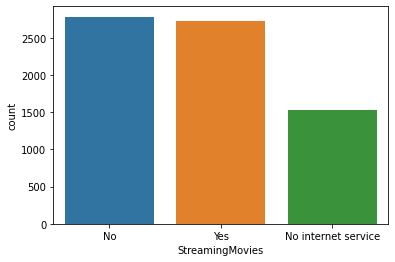

                Contract  Ration
Month-to-month      3875  55.019
Two year            1695  24.066
One year            1473  20.914
##########################################


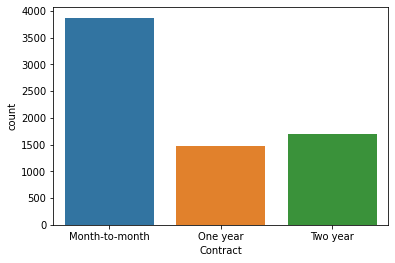

     PaperlessBilling  Ration
Yes              4171  59.222
No               2872  40.778
##########################################


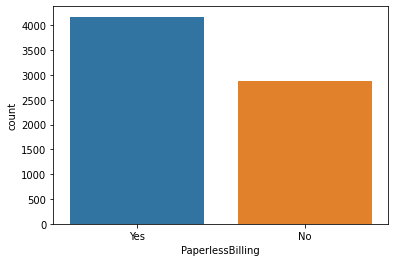

                           PaymentMethod  Ration
Electronic check                    2365  33.579
Mailed check                        1612  22.888
Bank transfer (automatic)           1544  21.922
Credit card (automatic)             1522  21.610
##########################################


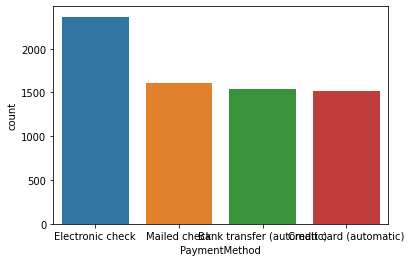

   SeniorCitizen  Ration
0           5901  83.785
1           1142  16.215
##########################################


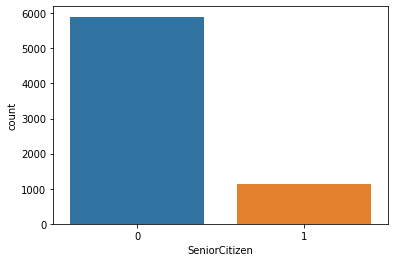

   Churn  Ration
0   5174  73.463
1   1869  26.537
##########################################


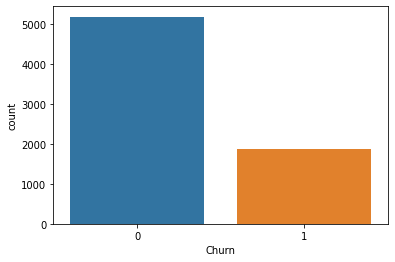

In [16]:
cat_summary_df(df)

In [17]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [18]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
1%         1.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


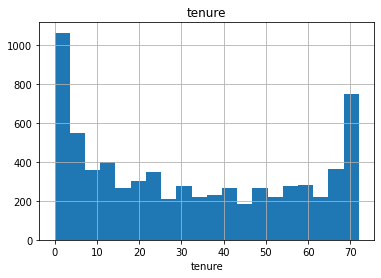

count   7043.000
mean      64.762
std       30.090
min       18.250
1%        19.200
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


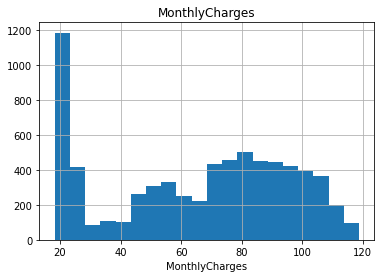

count   7032.000
mean    2283.300
std     2266.771
min       18.800
1%        19.900
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


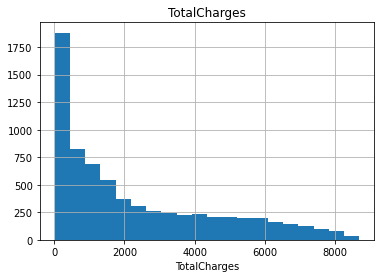

In [19]:
num_summary_df(df)

In [20]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("#############################################")

In [21]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [22]:
target_summary_with_num_df(df, "Churn")

       tenure
Churn        
0      37.570
1      17.979
#############################################
       MonthlyCharges
Churn                
0              61.265
1              74.441
#############################################
       TotalCharges
Churn              
0          2555.344
1          1531.796
#############################################


In [35]:
def target_summary_with_cat(dataframe, target, categorical_col):
  print(categorical_col)
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                      "Count": dataframe[categorical_col].value_counts(),
                      "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}))
  print("#############################################")

In [36]:
def target_summary_with_cat_df(dataframe, target):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in cat_cols:
    target_summary_with_cat(dataframe, target, col)

In [37]:
target_summary_with_cat_df(df, "Churn")

gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476
#############################################
Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303
#############################################
Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959
#############################################
PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317
#############################################
MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184
#############################################
InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   

## Correlation Analysis

In [38]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


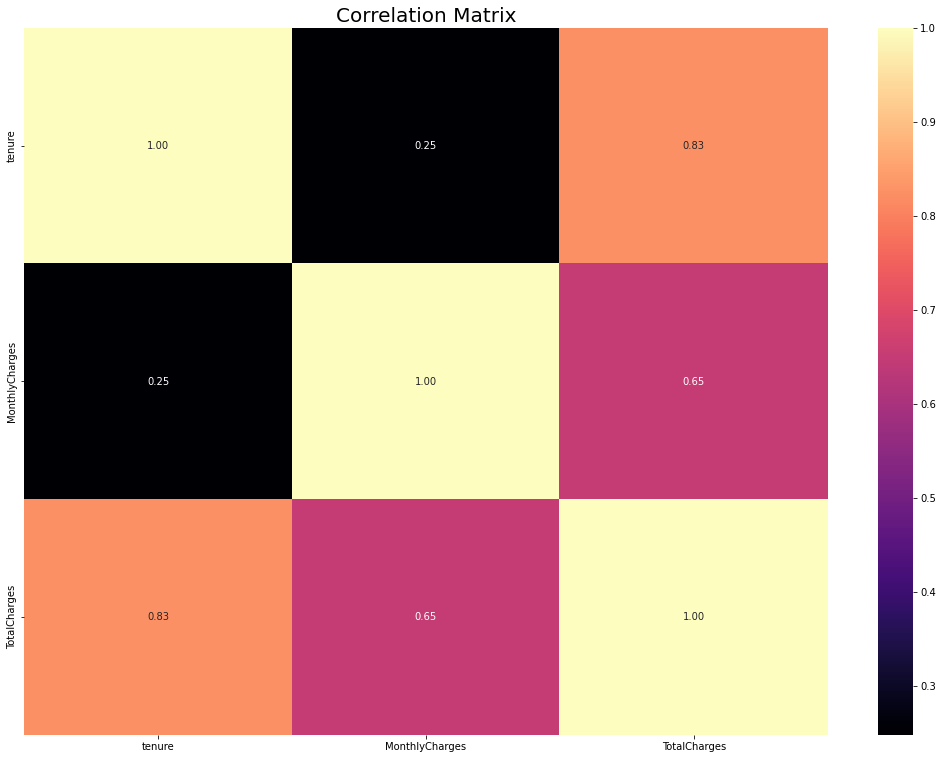

In [39]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [40]:
def high_correlated_cols(dataframe, plot=False, corr_th = 0.90):
  corr = dataframe.corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

  if drop_list == []:
    print("############## After Correlation Analysis, You Don't Need to Remove Variables ##############")

  if plot:
    sns.set(rc = {'figure.figsize':(18,13)})
    sns.heatmap(corr, cmap="RdBu")
    plt.show()
  return drop_list

############## After Correlation Analysis, You Don't Need to Remove Variables ##############


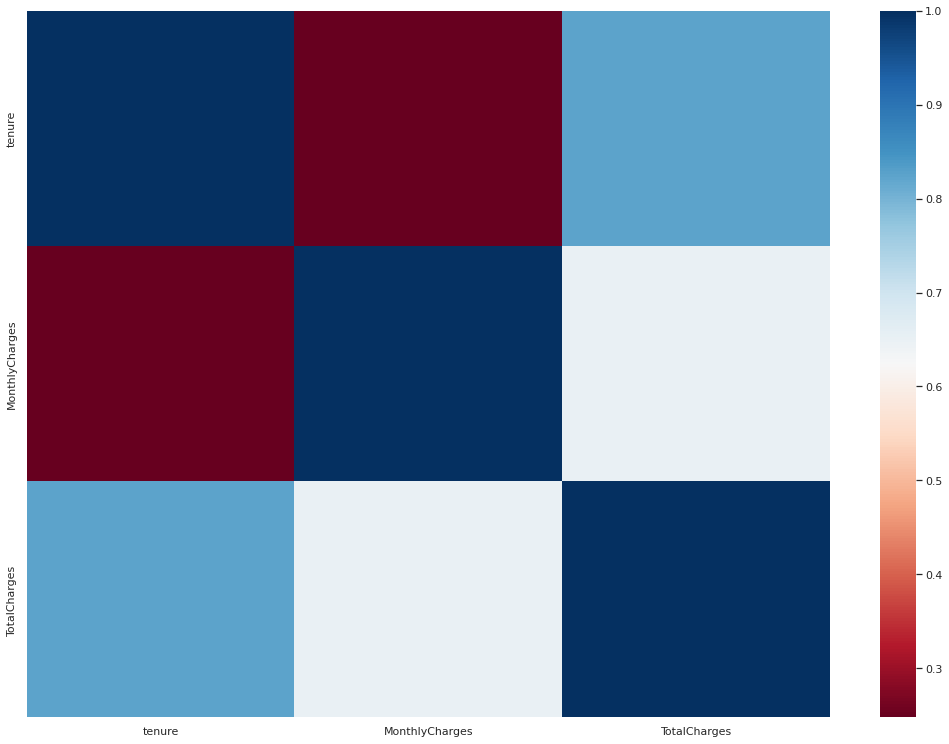

[]

In [42]:
high_correlated_cols(df[num_cols], plot=True)

In [43]:
df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000
MonthlyCharges    0.193
SeniorCitizen     0.151
TotalCharges     -0.199
tenure           -0.352
dtype: float64

# Feature Engineering

## Missing Value Analysis

In [44]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [45]:
def missing_value_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [46]:
na_columns = missing_value_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [50]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [51]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Base Model Setup


In [52]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [53]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [54]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=46).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")

Accuracy: 0.7875
Recall: 0.6386
Precision: 0.5017
F1: 0.562
Auc: 0.7332


In [55]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

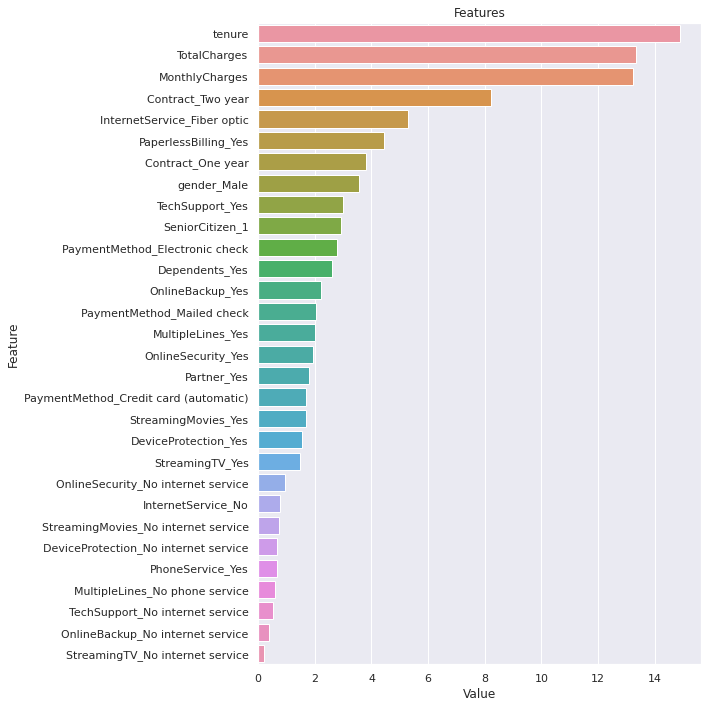

In [57]:
plot_importance(catboost_model, X)

## Outlier Analysis

In [58]:
def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [59]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [60]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [63]:
for col in num_cols:
  print(col, check_outlier(df, col))
  if check_outlier(df, col):
    replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


## Feature Extraction

In [64]:
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [65]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


## Encoding Scaling

In [69]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")

Observations: 7043
Variables: 31
Cat_cols: 24
Num_cols: 6
Cat_but_car: 1


In [70]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [71]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

In [74]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn","NEW_TotalServices"]]
def one_hot_encoding(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

In [75]:
df = one_hot_encoding(df, cat_cols, drop_first=True)

In [76]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


## Modeling

In [77]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=46).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.66
Precision: 0.49
F1: 0.56
Auc: 0.74


In [78]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

    Value                                Feature
10  9.853                           NEW_Increase
11  9.347                    NEW_AVG_Service_Fee
7   8.931                           TotalCharges
3   8.543                                 tenure
6   7.826                         MonthlyCharges
9   6.439                        NEW_AVG_Charges
39  5.659                          NEW_Engaged_1
29  3.966                      Contract_Two year
5   3.964                       PaperlessBilling
0   2.620                                 gender
14  2.469            InternetService_Fiber optic
8   1.868                      NEW_TotalServices
13  1.846                      MultipleLines_Yes
21  1.751                   DeviceProtection_Yes
31  1.652         PaymentMethod_Electronic check
38  1.535                        SeniorCitizen_1
2   1.531                             Dependents
37  1.324               NEW_TENURE_YEAR_5-6 Year
25  1.271                        StreamingTV_Yes
23  1.251           

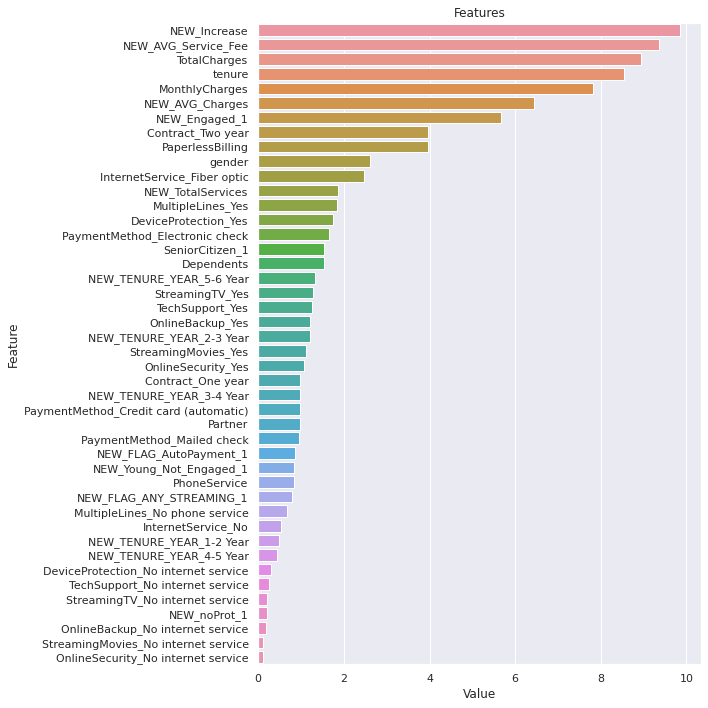

In [79]:
plot_importance(catboost_model, X)